In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from gtfparse import read_gtf
import bioframe
from matplotlib_venn import venn2, venn2_circles
import warnings
warnings.filterwarnings('ignore')

## Count which peaks are present in each dataset

In [22]:
human_znf143_peaks = pd.read_csv('./peaks/human_ZNF143_all_peaks.merged.motifs.bed', 
                                 sep = '\t', header = None)
human_znf143_peaks.columns = ['chrom', 'start', 'end', 'sbs1', 'sbs2']
human_znf143_peaks['sbs1'] = np.sign(human_znf143_peaks['sbs1'])
human_znf143_peaks['sbs2'] = np.sign(human_znf143_peaks['sbs2'])
human_znf143_peaks['sbs1_and_sbs2'] = [1 if x==2 else 0 for x in human_znf143_peaks['sbs1']+human_znf143_peaks['sbs2']]
human_znf143_peaks['sbs1_or_sbs2'] = np.sign(human_znf143_peaks['sbs1']+human_znf143_peaks['sbs2'])
sbs_motifs_data = human_znf143_peaks[['sbs1', 'sbs2', 'sbs1_and_sbs2', 'sbs1_or_sbs2']]
human_znf143_peaks = human_znf143_peaks.drop(['sbs1', 'sbs2', 'sbs1_and_sbs2', 'sbs1_or_sbs2'], axis = 1)
human_znf143_peaks.head()

,chrom,start,end
0,chr1,10017,10440
1,chr1,29176,29611
2,chr1,267829,268188
3,chr1,586021,586321
4,chr1,629749,630128


In [23]:
znf143_peaks = sorted(os.listdir('./peaks/'))
znf143_peaks = [x for x in znf143_peaks if '.bed' in x and 'ZNF143' in x and 'human' not in x and 'mouse' not in x]

for peak_set in znf143_peaks:
    name_dataset = peak_set.replace('_ZNF143_ChIPseq', '').replace('_ZNF143_ChIPexo', '').replace('.bed', '')
    znf143_peaks_dataset = pd.read_csv('./peaks/' + peak_set, sep = '\t', header = None)
    znf143_peaks_dataset = znf143_peaks_dataset[[0, 1, 2, 3, 4, 5]]
    znf143_peaks_dataset.columns = ['chrom', 'start', 'end', 'name', 'score', 'strand']
    human_znf143_peaks = bioframe.count_overlaps(human_znf143_peaks, znf143_peaks_dataset)
    human_znf143_peaks.columns = list(human_znf143_peaks.columns[:-1]) + [name_dataset]
    human_znf143_peaks[name_dataset] = np.sign(human_znf143_peaks[name_dataset])

human_znf143_peaks['total'] = human_znf143_peaks.drop(['chrom', 'start', 'end'], axis = 1).sum(axis = 1).values
human_znf143_peaks.head()

,chrom,start,end,Cobo_Macrophages_rep1,Cobo_Macrophages_rep2,ENCODE_GM12878_ENCLB209ACW,ENCODE_GM12878_ENCLB209ACX,ENCODE_GM12878_ENCLB901VQJ,ENCODE_H1_ENCLB209ABL,ENCODE_H1_ENCLB209AIM,...,Ngondo-Mbongo_K562,Tao_BE2C,Tenen_U937,Treloar_MCF7_rep1,Treloar_MCF7_rep2,Wang_CUTLL,Yan_LoVo,Zhang_HEC1B_AID_ZNF143_ChIPnexus,Zhang_HEC1B_ZNF143_ChIPnexus,total
0,chr1,10017,10440,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,chr1,29176,29611,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,chr1,267829,268188,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,1,1,4
3,chr1,586021,586321,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,1,1,4
4,chr1,629749,630128,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,1,5


## Count antibody-specific and cell-type-specific peaks

In [24]:
antibodies = pd.read_csv('antibodies.txt', sep = '\t')
proteintech_samples = antibodies[antibodies['Antibody'] == 'anti-ZNF143 Proteintech 16618-1-AP']['Sample'].values
proteintech_samples = [x.replace('_ZNF143_ChIPseq', '').replace('_ZNF143_ChIPexo', '') for x in proteintech_samples if 'Zfp143' not in x]
proteintech_samples = [x for x in proteintech_samples if x in human_znf143_peaks.columns]

proteintech_datasets_summary = human_znf143_peaks[proteintech_samples]
other_datasets_summary = human_znf143_peaks[[x for x in human_znf143_peaks.columns if x not in proteintech_samples]]
other_datasets_summary = other_datasets_summary.drop(['chrom', 'start', 'end', 'total'], axis = 1)

human_znf143_peaks['proteintech'] = [1 if y==0 and x>0 else 0 for (x, y) in zip(proteintech_datasets_summary.sum(axis = 1).values, other_datasets_summary.sum(axis = 1).values)]

In [25]:
cell_lines = ['Macrophages', 'GM12878', 'H1', 'H9', 'HeLa', 'HepG2', 'K562', 'WTC11', 
              'HEK293', 'HPB_ALL', 'BE2C', 'U937', 'MCF7', 'CUTLL', 'LoVo', 'HEC1B']

# Count peaks present only in one cell type
cell_line_specific_peaks = np.zeros(len(human_znf143_peaks))
for cell_line in cell_lines:
    cell_line_specific_index = []
    cell_line_peak_counts = human_znf143_peaks[[x for x in human_znf143_peaks.columns if cell_line in x]].sum(axis = 1)
    for i in range(0, len(cell_line_peak_counts)):
        if cell_line_peak_counts[i] == human_znf143_peaks['total'].values[i]:
            cell_line_specific_index.append(1)
        else:
            cell_line_specific_index.append(0)
    cell_line_specific_peaks = cell_line_specific_peaks + np.array(cell_line_specific_index)
human_znf143_peaks['cell_line_specific'] = [int(x) for x in np.sign(cell_line_specific_peaks)]

# Count peaks present in all cell lines
cell_line_specific_peaks = np.zeros(len(human_znf143_peaks))
for cell_line in cell_lines:
    cell_line_specific_index = []
    cell_line_peak_counts = human_znf143_peaks[[x for x in human_znf143_peaks.columns if cell_line in x]].sum(axis = 1)
    cell_line_specific_peaks = cell_line_specific_peaks + np.sign(cell_line_peak_counts)    
human_znf143_peaks['conserved'] = [1 if x == 16 else 0 for x in cell_line_specific_peaks]
human_znf143_peaks['shared_>=10'] = [1 if x >= 10 else 0 for x in cell_line_specific_peaks]
human_znf143_peaks['shared_>=5'] = [1 if x >= 5 else 0 for x in cell_line_specific_peaks]

In [26]:
human_znf143_peaks = pd.concat([human_znf143_peaks, sbs_motifs_data], axis = 1)
human_znf143_peaks.head()

,chrom,start,end,Cobo_Macrophages_rep1,Cobo_Macrophages_rep2,ENCODE_GM12878_ENCLB209ACW,ENCODE_GM12878_ENCLB209ACX,ENCODE_GM12878_ENCLB901VQJ,ENCODE_H1_ENCLB209ABL,ENCODE_H1_ENCLB209AIM,...,total,proteintech,cell_line_specific,conserved,shared_>=10,shared_>=5,sbs1,sbs2,sbs1_and_sbs2,sbs1_or_sbs2
0,chr1,10017,10440,0,0,0,0,1,0,0,...,1,1,1,0,0,0,0,0,0,0
1,chr1,29176,29611,0,0,0,0,1,0,0,...,1,1,1,0,0,0,1,0,0,1
2,chr1,267829,268188,0,0,1,0,1,0,0,...,4,1,0,0,0,0,0,0,0,0
3,chr1,586021,586321,0,0,1,0,1,0,0,...,4,1,0,0,0,0,1,0,0,1
4,chr1,629749,630128,0,0,0,0,0,0,0,...,5,0,0,0,0,0,0,0,0,0


## Number of peaks shared across datasets

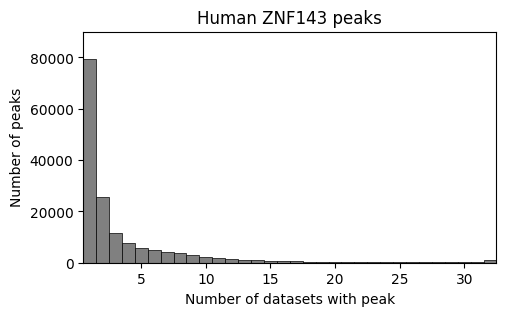

In [27]:
plt.figure(figsize = (5/30*32, 3))
plt.title('Human ZNF143 peaks', fontsize = 12)
plt.bar(np.unique(human_znf143_peaks['total'], return_counts = 1)[0],
        np.unique(human_znf143_peaks['total'], return_counts = 1)[1], 
        edgecolor = 'k', color = 'grey', linewidth = 0.5, width = 1)
plt.xlim((0.5, 32.5))
plt.ylim((0, 90000))
plt.xlabel('Number of datasets with peak', fontsize = 10)
plt.ylabel('Number of peaks', fontsize = 10)
plt.show()

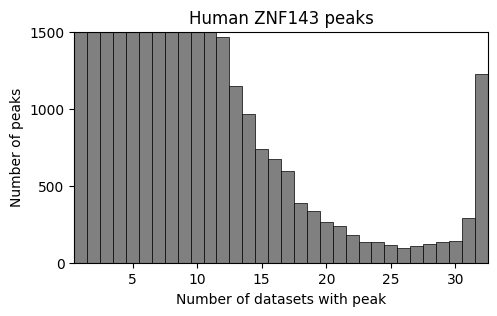

In [28]:
plt.figure(figsize = (5/30*32, 3))
plt.title('Human ZNF143 peaks', fontsize = 12)
plt.bar(np.unique(human_znf143_peaks['total'], return_counts = 1)[0],
        np.unique(human_znf143_peaks['total'], return_counts = 1)[1], 
        edgecolor = 'k', color = 'grey', linewidth = 0.5, width = 1)
plt.xlim((0.5, 32.5))
plt.ylim((0, 1500))
plt.yticks([0, 500, 1000, 1500])
plt.xlabel('Number of datasets with peak', fontsize = 10)
plt.ylabel('Number of peaks', fontsize = 10)
plt.show()

## Motifs in the peaks

In [29]:
fraction_peaks_with_motif = []
for dataset_number in np.arange(0, 32):
    fractions = human_znf143_peaks[human_znf143_peaks['total'] == dataset_number+1][['sbs1', 'sbs2', 'sbs1_and_sbs2']]
    count_sbs1_sbs2 = len(fractions[fractions['sbs1_and_sbs2'] == 1])
    count_sbs1 = len(fractions[(fractions['sbs1'] == 1) & (fractions['sbs1_and_sbs2'] != 1)])
    count_sbs2 = len(fractions[(fractions['sbs2'] == 1) & (fractions['sbs1_and_sbs2'] != 1)])
    counts_no_motif = len(fractions)-count_sbs1_sbs2-count_sbs1-count_sbs2
    fractions = [count_sbs1_sbs2, count_sbs1, count_sbs2, counts_no_motif]
    fractions = np.array(fractions)/np.sum(fractions)

    fraction_peaks_with_motif.append(fractions)
fraction_peaks_with_motif = pd.DataFrame({'Number_of_datasets': np.arange(0, 32)+1, 
                                          'SBS1_SBS2': [x[0] for x in fraction_peaks_with_motif],
                                          'SBS1': [x[1] for x in fraction_peaks_with_motif],
                                          'SBS2': [x[2] for x in fraction_peaks_with_motif],
                                          'No_motif': [x[3] for x in fraction_peaks_with_motif]})
fraction_peaks_with_motif.head()

,Number_of_datasets,SBS1_SBS2,SBS1,SBS2,No_motif
0,1,0.049095,0.247365,0.032654,0.670886
1,2,0.069716,0.340578,0.033858,0.555848
2,3,0.064890,0.329728,0.034063,0.571319
3,4,0.064642,0.313993,0.034787,0.586578
4,5,0.059392,0.310256,0.034012,0.596340


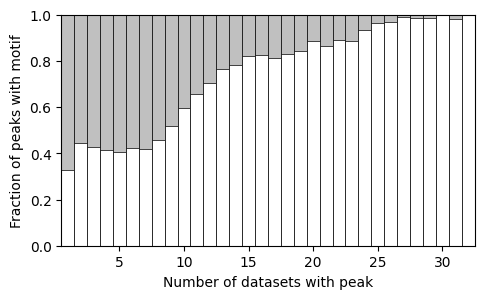

In [30]:
plt.figure(figsize = (5/30*32, 3))
plt.bar(fraction_peaks_with_motif['Number_of_datasets'], 
        fraction_peaks_with_motif['SBS1_SBS2']+fraction_peaks_with_motif['SBS1']+fraction_peaks_with_motif['SBS2']+fraction_peaks_with_motif['No_motif'], 
        edgecolor = 'k', width = 1, linewidth = 0.5, color = 'silver')
plt.bar(fraction_peaks_with_motif['Number_of_datasets'], 
        fraction_peaks_with_motif['SBS1_SBS2']+fraction_peaks_with_motif['SBS1']+fraction_peaks_with_motif['SBS2'], 
        edgecolor = 'k', width = 1, linewidth = 0.5, color = 'white')
plt.xlabel('Number of datasets with peak', fontsize = 10)
plt.ylabel('Fraction of peaks with motif', fontsize = 10)
plt.xlim((0.5, 32.5))
plt.ylim((0, 1))
plt.show()

## Category of peaks

In [31]:
fraction_peaks = []
for dataset_number in np.arange(0, 32):
    fractions = human_znf143_peaks[human_znf143_peaks['total'] == dataset_number+1][['proteintech', 'cell_line_specific', 
                                                                                     'conserved', 'shared_>=10', 'shared_>=5', 'total']]
    count_proteintech = len(fractions[fractions['proteintech'] == 1])
    count_cell_line_specific = len(fractions[(fractions['cell_line_specific'] == 1) & (fractions['proteintech'] != 1)])
    count_conserved = len(fractions[fractions['conserved'] == 1])
    count_shared_10 = len(fractions[fractions['shared_>=10'] == 1])-count_conserved
    count_shared_5 = len(fractions[fractions['shared_>=5'] == 1])-count_shared_10-count_conserved
    count_shared_1 = len(fractions)-count_shared_5-count_shared_10-count_conserved-count_cell_line_specific-count_proteintech
    
    fractions = [count_proteintech, count_cell_line_specific, count_shared_1, count_shared_5, count_shared_10, count_conserved]
    fractions = np.array(fractions)/np.sum(fractions)

    fraction_peaks.append(fractions)
fraction_peaks = pd.DataFrame({'Number_of_datasets': np.arange(0, 32)+1, 
                               'Proteintech': [x[0] for x in fraction_peaks],
                               'Cell_line_specific': [x[1] for x in fraction_peaks],
                               'Shared_1': [x[2] for x in fraction_peaks],
                               'Shared_5': [x[3] for x in fraction_peaks],
                               'Shared_10': [x[4] for x in fraction_peaks],
                               'Conserved': [x[5] for x in fraction_peaks]})
fraction_peaks

,Number_of_datasets,Proteintech,Cell_line_specific,Shared_1,Shared_5,Shared_10,Conserved
0,1,0.417545,0.582455,0.000000,0.000000,0.000000,0.000000
1,2,0.547373,0.231433,0.221193,0.000000,0.000000,0.000000
2,3,0.579579,0.011837,0.408584,0.000000,0.000000,0.000000
3,4,0.579829,0.003764,0.416407,0.000000,0.000000,0.000000
4,5,0.580628,0.001554,0.380870,0.036948,0.000000,0.000000
5,6,0.560394,0.000000,0.284907,0.154700,0.000000,0.000000
6,7,0.522507,0.000000,0.134318,0.343175,0.000000,0.000000
7,8,0.458746,0.000000,-0.008251,0.549505,0.000000,0.000000
8,9,0.310480,0.000000,-0.088475,0.777995,0.000000,0.000000
9,10,0.113849,0.000000,-0.100255,0.986406,0.000000,0.000000


Proteintech-specific: 69579
Cell-line-specific: 52274
Shared (2-4 cell lines): 17084
Shared (5-9 cell lines): 16249
Shared (10-15 cell lines): 2789
Conserved (16 cell lines): 1456


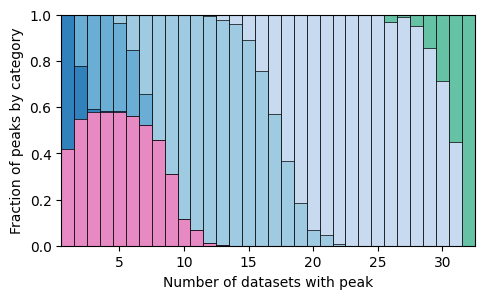

In [32]:
proteintech = len(human_znf143_peaks[human_znf143_peaks['proteintech'] == 1])
cell_line_specific = len(human_znf143_peaks[(human_znf143_peaks['cell_line_specific'] == 1) & (human_znf143_peaks['proteintech'] != 1)])
conserved_num = len(human_znf143_peaks[human_znf143_peaks['conserved'] == 1])
shared_10_num = len(human_znf143_peaks[human_znf143_peaks['shared_>=10'] == 1])-conserved_num
shared_5_num = len(human_znf143_peaks[human_znf143_peaks['shared_>=5'] == 1])-shared_10_num-conserved_num
shared_1_num = len(human_znf143_peaks)-proteintech-cell_line_specific-shared_5_num-shared_10_num-conserved_num
print('Proteintech-specific:', proteintech)
print('Cell-line-specific:', cell_line_specific)
print('Shared (2-4 cell lines):', shared_1_num)
print('Shared (5-9 cell lines):', shared_5_num)
print('Shared (10-15 cell lines):', shared_10_num)
print('Conserved (16 cell lines):', conserved_num)

plt.figure(figsize = (5/30*32, 3))
plt.bar(fraction_peaks['Number_of_datasets'], 
        fraction_peaks['Proteintech']+fraction_peaks['Cell_line_specific']+fraction_peaks['Shared_1']+fraction_peaks['Shared_5']+fraction_peaks['Shared_10']+fraction_peaks['Conserved'],
        edgecolor = 'k', width = 1, linewidth = 0.5, color = '#66C2A5')
plt.bar(fraction_peaks['Number_of_datasets'], 
        fraction_peaks['Proteintech']+fraction_peaks['Cell_line_specific']+fraction_peaks['Shared_1']+fraction_peaks['Shared_5']+fraction_peaks['Shared_10'],
        edgecolor = 'k', width = 1, linewidth = 0.5, color = '#C7DAEF')
plt.bar(fraction_peaks['Number_of_datasets'], 
        fraction_peaks['Proteintech']+fraction_peaks['Cell_line_specific']+fraction_peaks['Shared_1']+fraction_peaks['Shared_5'],
        edgecolor = 'k', width = 1, linewidth = 0.5, color = '#9ECAE2')
plt.bar(fraction_peaks['Number_of_datasets'], 
        fraction_peaks['Proteintech']+fraction_peaks['Cell_line_specific']+fraction_peaks['Shared_1'],
        edgecolor = 'k', width = 1, linewidth = 0.5, color = '#6AAED6')
plt.bar(fraction_peaks['Number_of_datasets'], 
        fraction_peaks['Proteintech']+fraction_peaks['Cell_line_specific'], 
        edgecolor = 'k', width = 1, linewidth = 0.5, color = '#3181BD')
plt.bar(fraction_peaks['Number_of_datasets'], 
        fraction_peaks['Proteintech'], 
        edgecolor = 'k', width = 1, linewidth = 0.5, color = '#E78AC3')

plt.xlabel('Number of datasets with peak', fontsize = 10)
plt.ylabel('Fraction of peaks by category', fontsize = 10)
plt.xlim((0.5, 32.5))
plt.ylim((0, 1))
plt.show()

## Assign conserved ZNF143 peaks to target genes

In [46]:
conserved_znf143_peaks = human_znf143_peaks[human_znf143_peaks['conserved'] == 1][['chrom', 'start', 'end']]
conserved_znf143_peaks['name'] = ['ZNF143_conserved_' + str(i+1) for i in range(len(conserved_znf143_peaks))]
print('Number of conserved peaks:', len(conserved_znf143_peaks))

conserved_znf143_peaks.head()

Number of conserved peaks: 1456


,chrom,start,end,name
33,chr1,958597,959914,ZNF143_conserved_1
84,chr1,1115702,1117021,ZNF143_conserved_2
167,chr1,1374378,1376685,ZNF143_conserved_3
169,chr1,1398948,1401160,ZNF143_conserved_4
171,chr1,1406596,1408222,ZNF143_conserved_5


In [47]:
motifs_sbs1 = pd.read_csv('./conserved_genes/ZFP143_SBS1_denovo_motifs.hg38.bed', sep = '\t', header = None)
motifs_sbs1.columns = ['chrom', 'start', 'end', 'name', 'strand', 'score']
motifs_sbs1 = motifs_sbs1[['chrom', 'start', 'end', 'name', 'score', 'strand']]

motifs_sbs2 = pd.read_csv('./conserved_genes/ZFP143_SBS2_denovo_motifs.hg38.bed', sep = '\t', header = None)
motifs_sbs2.columns = ['chrom', 'start', 'end', 'name', 'strand', 'score']
motifs_sbs2 = motifs_sbs2[['chrom', 'start', 'end', 'name', 'score', 'strand']]

In [48]:
peaks_overlap_sbs1 = bioframe.overlap(conserved_znf143_peaks, motifs_sbs1, suffixes=('', '_sbs1')).dropna()
peaks_overlap_sbs2 = bioframe.overlap(conserved_znf143_peaks, motifs_sbs2, suffixes=('', '_sbs2')).dropna()
peaks_with_sbs1 = list(np.unique(peaks_overlap_sbs1['name']))
peaks_with_sbs2 = list(np.unique(peaks_overlap_sbs2['name']))
peaks_with_sbs1_and_sbs2 = list(set.intersection(set(peaks_with_sbs1), set(peaks_with_sbs2)))
peaks_only_sbs1 = [x for x in peaks_with_sbs1 if x not in peaks_with_sbs2]
peaks_only_sbs2 = [x for x in peaks_with_sbs2 if x not in peaks_with_sbs1]

peaks_overlap_sbs1_sbs2 = bioframe.overlap(bioframe.overlap(conserved_znf143_peaks, motifs_sbs1, suffixes=('', '_sbs1')), motifs_sbs2, suffixes=('', '_sbs2'))
peaks_with_overlapping_sbs1_and_sbs2 = []
for peak in peaks_with_sbs1_and_sbs2:
    peak_motif_pairs = peaks_overlap_sbs1_sbs2[peaks_overlap_sbs1_sbs2['name'] == peak]
    for pair in peak_motif_pairs.values:
        start_sbs1, end_sbs1, start_sbs2, end_sbs2 = pair[5], pair[6], pair[11], pair[12]
        if max(start_sbs1, start_sbs2) <= min(end_sbs1, end_sbs2):
            peaks_with_overlapping_sbs1_and_sbs2.append(peak)
            break

print('SBS1 or SBS2:', len(np.unique(np.hstack((peaks_with_sbs1, peaks_with_sbs2)))) / len(conserved_znf143_peaks) * 100)
print('SBS1 and SBS2:', len(peaks_with_sbs1_and_sbs2) / len(conserved_znf143_peaks) * 100)
print('SBS1 and SBS2 (overlapping):', len(peaks_with_overlapping_sbs1_and_sbs2) / len(conserved_znf143_peaks) * 100)
print('SBS1 only:', len(peaks_only_sbs1) / len(np.unique(conserved_znf143_peaks['name'])) * 100)
print('SBS2 only:', len(peaks_only_sbs2) / len(np.unique(conserved_znf143_peaks['name'])) * 100)

SBS1 or SBS2: 99.51923076923077
SBS1 and SBS2: 78.77747252747253
SBS1 and SBS2 (overlapping): 73.1456043956044
SBS1 only: 19.986263736263737
SBS2 only: 0.7554945054945055


In [49]:
# Read GTF with comprehensive gene annotation
genes = read_gtf('/DATA/users/magnitov/znf143/genome/gencode.v42.annotation.gtf')

# Filter transcripts of protein coding or long non-coding RNAs with high confidence
genes = genes[genes['feature'] == 'transcript']
genes = genes[genes['transcript_support_level'].isin(['1', '2', '3', '4', '5'])]
genes = genes[genes['transcript_type'].isin(['protein_coding', 'lncRNA', 'processed_transcript'])]

genes = genes[['seqname', 'start', 'end', 'strand', 'gene_id', 'gene_name', 'gene_type', 'transcript_id', 'transcript_type', 'transcript_support_level']]
genes.head()

INFO:root:Extracted GTF attributes: ['gene_id', 'gene_type', 'gene_name', 'level', 'tag', 'transcript_id', 'transcript_type', 'transcript_name', 'transcript_support_level', 'havana_transcript', 'exon_number', 'exon_id', 'hgnc_id', 'havana_gene', 'ont', 'protein_id', 'ccdsid', 'artif_dupl']


,seqname,start,end,strand,gene_id,gene_name,gene_type,transcript_id,transcript_type,transcript_support_level
1,chr1,11869,14409,+,ENSG00000290825.1,DDX11L2,lncRNA,ENST00000456328.2,lncRNA,1
30,chr1,29554,31097,+,ENSG00000243485.5,MIR1302-2HG,lncRNA,ENST00000473358.1,lncRNA,5
34,chr1,30267,31109,+,ENSG00000243485.5,MIR1302-2HG,lncRNA,ENST00000469289.1,lncRNA,5
41,chr1,34554,36081,-,ENSG00000237613.2,FAM138A,lncRNA,ENST00000417324.1,lncRNA,1
45,chr1,35245,36073,-,ENSG00000237613.2,FAM138A,lncRNA,ENST00000461467.1,lncRNA,3


In [50]:
def get_tss(genes, margin_upstream, margin_downstream):
    genes_tss = []
    for gene in genes.values:
        if gene[3] == '+':
            genes_tss.append([gene[0], gene[1]-margin_upstream, gene[1]+margin_downstream, gene[4], gene[5], gene[3], gene[6], gene[7], gene[8], gene[9]])
        else:
            genes_tss.append([gene[0], gene[2]-margin_downstream, gene[2]+margin_upstream, gene[4], gene[5], gene[3], gene[6], gene[7], gene[8], gene[9]])

    genes_tss = pd.DataFrame(genes_tss)
    genes_tss.columns = ['chrom', 'start', 'end', 'gene_id', 'gene_name', 'strand', 'gene_type', 'transcript_id', 'transcript_type', 'transcript_support']
    return(genes_tss)

In [51]:
# Find overlap between peaks and TSS regions
peaks_overlap_genes = bioframe.overlap(conserved_znf143_peaks, get_tss(genes, 2000, 1000), suffixes=('', '_genes'))
peaks_overlap_genes = peaks_overlap_genes.drop(['chrom_genes'], axis = 1).dropna()
peaks_overlap_genes['strand_genes'] = [str(x) for x in peaks_overlap_genes['strand_genes']]
peaks_overlap_genes.index = np.arange(len(peaks_overlap_genes))

In [52]:
# Replace transcript coordinates with actual coordinates instead of widened TSS coordinates
peaks_overlap_genes = peaks_overlap_genes.merge(genes, left_on = 'transcript_id_genes', right_on = 'transcript_id')
peaks_overlap_genes = peaks_overlap_genes.drop(['seqname', 'strand', 'gene_id', 'transcript_id', 
                                                'gene_name', 'gene_type', 'transcript_type', 'transcript_support_level'], axis = 1)
peaks_overlap_genes['start_genes'] = peaks_overlap_genes['start_y']
peaks_overlap_genes['end_genes'] = peaks_overlap_genes['end_y']
peaks_overlap_genes = peaks_overlap_genes.drop(['start_y', 'end_y'], axis = 1)
peaks_overlap_genes.columns = ['chrom', 'start_peak', 'end_peak', 'name_peak',
                               'start_gene', 'end_gene', 'gene_id', 'gene_name', 'strand_gene', 'gene_type', 
                               'transcript_id', 'transcript_type', 'transcript_support']

In [53]:
# Add distance between transcript and center of the peak
distances = []
for peak_transcript_pair in peaks_overlap_genes.values:
    if peak_transcript_pair[8] == '+':
        distances.append(peak_transcript_pair[4] - (peak_transcript_pair[1]+peak_transcript_pair[2])//2)
    else:
        distances.append(peak_transcript_pair[5] - (peak_transcript_pair[1]+peak_transcript_pair[2])//2)
peaks_overlap_genes['distance'] = [abs(x) for x in distances]
peaks_overlap_genes = peaks_overlap_genes[peaks_overlap_genes['distance'] <= 2000]
peaks_overlap_genes.index = np.arange(len(peaks_overlap_genes))

In [54]:
# For each gene find the transcript with highest (i) transcript support level, (ii) distance to peak, (iii) length
indices_to_keep = []
for gene_id in np.unique(peaks_overlap_genes['gene_id']):
    overlaps_gene = peaks_overlap_genes[peaks_overlap_genes['gene_id'] == gene_id]
    overlaps_gene['length'] = overlaps_gene['end_gene']-overlaps_gene['start_gene']
    if len(overlaps_gene) == 1:
        indices_to_keep.append(overlaps_gene.index[0])
    else:
        ranked_transcripts = overlaps_gene.sort_values(['transcript_support', 'distance', 'length'], ascending = [1, 1, 0])
        indices_to_keep.append(ranked_transcripts.index[0])

peaks_overlap_genes = peaks_overlap_genes.iloc[np.sort(indices_to_keep)]
peaks_overlap_genes.index = np.arange(len(peaks_overlap_genes))

In [55]:
# For peaks that were associated with multiple genes on same strand, try to find more appropriate one based on
# (i) transcript type, (ii) transcript support level and (iii) presence of genes with lower confidence at the same location
indices_to_remove = []
for peak in np.unique(peaks_overlap_genes['name_peak']):
    peak_genes = peaks_overlap_genes[peaks_overlap_genes['name_peak'] == peak]
    
    if (len(peak_genes[peak_genes['strand_gene'] == '+']) > 1) or (len(peak_genes[peak_genes['strand_gene'] == '-']) > 1):
        if (len(peak_genes[peak_genes['strand_gene'] == '+']) > 1):
            ambiguous_pairs = peak_genes[peak_genes['strand_gene'] == '+'][['gene_name', 'chrom', 'start_gene', 'end_gene', 'strand_gene', 'transcript_type', 'transcript_support', 'distance']]
        else:
            ambiguous_pairs = peak_genes[peak_genes['strand_gene'] == '-'][['gene_name', 'chrom', 'start_gene', 'end_gene', 'strand_gene', 'transcript_type', 'transcript_support', 'distance']]
        
        ambiguous_indices = ambiguous_pairs.index

        if len(ambiguous_pairs[ambiguous_pairs['transcript_type'].isin(['protein_coding', 'lncRNA'])]) > 0 and len(ambiguous_pairs) > 1:
            ambiguous_pairs = ambiguous_pairs[ambiguous_pairs['transcript_type'].isin(['protein_coding', 'lncRNA'])]
        if len(ambiguous_pairs[ambiguous_pairs['transcript_support'].isin(['1', '2'])]) > 0 and len(ambiguous_pairs) > 1:
            ambiguous_pairs = ambiguous_pairs[ambiguous_pairs['transcript_support'].isin(['1', '2'])]    
        ambiguous_indices = [x for x in ambiguous_indices if x not in ambiguous_pairs.index]
        indices_to_remove = indices_to_remove + ambiguous_indices

peaks_overlap_genes = peaks_overlap_genes.drop(indices_to_remove)
peaks_overlap_genes.index = np.arange(len(peaks_overlap_genes))

In [56]:
# Add information about SBS1 or SBS2 motif presense in the peak
has_sbs1_motif_same_orientation, has_sbs2_motif_same_orientation = [], []
for peak_gene_pair in peaks_overlap_genes.values:
    motifs_associated_with_peak = peaks_overlap_sbs1_sbs2[peaks_overlap_sbs1_sbs2['name'] == peak_gene_pair[3]]
    
    gene_strand = peak_gene_pair[8]
    if gene_strand in motifs_associated_with_peak['strand_sbs1'].values:
        has_sbs1_motif_same_orientation.append(1)
    else:
        has_sbs1_motif_same_orientation.append(0)
        
    if gene_strand in motifs_associated_with_peak['strand_sbs2'].values:
        has_sbs2_motif_same_orientation.append(1)
    else:
        has_sbs2_motif_same_orientation.append(0)
        
peaks_overlap_genes['sbs1_motif'] = has_sbs1_motif_same_orientation
peaks_overlap_genes['sbs2_motif'] = has_sbs2_motif_same_orientation
peaks_overlap_genes['sbs1_and_sbs2_motif'] = [1 if x+y==2 else 0 for (x, y) in zip(peaks_overlap_genes['sbs1_motif'], peaks_overlap_genes['sbs2_motif'])]

In [57]:
peaks_overlap_genes.to_csv('./conserved_genes/conserved_ZNF143_peaks_GENCODE_genes_associations.txt', sep = '\t', header = 1, index = 0)

## Statistics for the final set of associations

In [58]:
print('Number of peaks associated:', len(np.unique(peaks_overlap_genes['name_peak'])), 
      '(' + str(round(len(np.unique(peaks_overlap_genes['name_peak']))/len(conserved_znf143_peaks)*100, 1)) + '% of peaks)')

unidirectional, bidirectional = 0, 0

for peak in np.unique(peaks_overlap_genes['name_peak']):
    peak_genes = peaks_overlap_genes[peaks_overlap_genes['name_peak'] == peak]
    if '+' in peak_genes['strand_gene'].values and '-' in peak_genes['strand_gene'].values:
        bidirectional += 1
    else:
        unidirectional += 1

print('Peaks associated with unidirectional promoters:', unidirectional,
      '(' + str(round(unidirectional/len(np.unique(peaks_overlap_genes['name_peak']))*100, 2)) + '%)')
print('Peaks associated with bidirectional promoters:', bidirectional, 
      '(' + str(round(bidirectional/len(np.unique(peaks_overlap_genes['name_peak']))*100, 2)) + '%)')

Number of peaks associated: 1257 (86.3% of peaks)
Peaks associated with unidirectional promoters: 841 (66.91%)
Peaks associated with bidirectional promoters: 416 (33.09%)


In [59]:
print('Number of genes associated:', len(np.unique(peaks_overlap_genes['gene_id'])))

gene_types_associated = pd.DataFrame(np.unique(peaks_overlap_genes['transcript_type'], return_counts = 1))
gene_types_associated = gene_types_associated.transpose().sort_values([1], ascending = 0)
gene_types_associated[2] = gene_types_associated[1] / np.sum(gene_types_associated[1])
gene_types_associated.columns = ['transcript_type', 'number_of_transcripts', 'fraction']
gene_types_associated

Number of genes associated: 1696


,transcript_type,number_of_transcripts,fraction
2,protein_coding,1501,0.885024
0,lncRNA,190,0.112028
1,processed_transcript,5,0.002948
